## SkyCast: Weather Classifier - Multiclass ML Model


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("C:/Users/TahaK/Downloads/weatherHistory.csv")
print(df.head())

# Check the distribution of the target variable (Summary)
print("\nTarget variable distribution:")
print(df['Summary'].value_counts())

# Check the distribution of PrecipType
print("\nPrecipType distribution:")
print(df['Precip Type'].value_counts())





                  Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.1036   
4                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                     251          15.8263           0               1015.13  

## Merging my target variable class into 3 Classes (Rainy, Cloudy and Clear)

In [3]:
# Define a function to group similar weather conditions into 3 categories
def map_weather(summary):
    if summary in ['Clear', 'Partly Cloudy', 'Dry', 'Breezy']:
        return 'Clear'
    elif summary in ['Overcast', 'Mostly Cloudy', 'Foggy', 'Humid and Mostly Cloudy', 
                     'Humid and Partly Cloudy', 'Humid and Overcast', 
                     'Windy and Overcast', 'Breezy and Overcast']:
        return 'Cloudy'
    elif summary in ['Light Rain', 'Drizzle', 'Rain', 'Windy and Foggy']:
        return 'Rainy'
    else:
        return 'Cloudy'  # Default category for rare cases
    
# Apply function to create a new column
df['Weather_Class'] = df['Summary'].apply(map_weather)

# Check class distribution
print(df['Weather_Class'].value_counts())


Weather_Class
Cloudy    53626
Clear     42711
Rainy       116
Name: count, dtype: int64


### Model Training 

### 🔧 Steps Involved:

### 1. Data Preparation:
Extracts features like temperature, humidity, pressure, etc.

Encodes the target labels (Weather_Class) into numeric form.

### 2. Class Balancing:
The dataset is imbalanced (e.g., fewer rainy samples).

Applies:

### Upsampling for Rainy class (to 800 samples).

### Downsampling for Cloudy and Clear classes (to 11,000 each).

Combines and shuffles the balanced dataset.

### 3. Feature Scaling:
Uses StandardScaler to normalize feature values.

### 4. Train-Test Split:
Splits data into training and testing sets (80/20 split).

### 5. SMOTE for Neural Network:
Applies SMOTE (Synthetic Minority Over-sampling) to training data only for the neural network to better learn from imbalanced classes.

### 6. Model Configuration & Training:
Trains three types of models:

🔸 Random Forest (3 configurations)

🔸 Logistic Regression (3 configurations)

🔸 Neural Network (3 architectures)

Each model is trained, evaluated, and compared using:

### Accuracy

### Balanced Accuracy

### Classification Report

Neural Networks are trained using:

Keras with early stopping and categorical crossentropy loss.

### 7. Best Model Selection:
For each model type, the configuration with the highest balanced accuracy is saved as the best.

### 8. Final Evaluation:
Prints performance metrics (accuracy, balanced accuracy, classification report) of the best models for each algorithm on the test set.



In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import numpy as np

# Step 1: Separate features and target
X = df[['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
        'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']]
y = df['Weather_Class']

# Step 2: Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Step 3-8: Resampling to handle imbalance
df_encoded = X.copy()
df_encoded['Weather_Class'] = y_encoded

rainy_label = le.transform(['Rainy'])[0]
cloudy_label = le.transform(['Cloudy'])[0]
clear_label = le.transform(['Clear'])[0]

rainy = df_encoded[df_encoded['Weather_Class'] == rainy_label]
cloudy = df_encoded[df_encoded['Weather_Class'] == cloudy_label]
clear = df_encoded[df_encoded['Weather_Class'] == clear_label]

rainy_upsampled = resample(rainy, replace=True, n_samples=800, random_state=42)
cloudy_downsampled = resample(cloudy, replace=False, n_samples=11000, random_state=42)
clear_downsampled = resample(clear, replace=False, n_samples=11000, random_state=42)

df_balanced = pd.concat([rainy_upsampled, cloudy_downsampled, clear_downsampled]).sample(frac=1, random_state=42)
X_balanced = df_balanced.drop(columns=['Weather_Class'])
y_balanced = df_balanced['Weather_Class']

# Step 9: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced)

# Split original balanced data for RF/LR
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X_scaled, y_balanced, test_size=0.2, random_state=42)

# Apply SMOTE for Neural Network training only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_orig, y_train_orig)
y_train_onehot = to_categorical(y_train_smote)
y_test_onehot = to_categorical(y_test)

# Neural Network Builder Function
def build_nn(input_dim, output_dim, units=[64], dropout=0.3, lr=0.001):
    model = Sequential()
    model.add(Dense(units[0], activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(dropout))

    for u in units[1:]:
        model.add(Dense(u, activation='relu'))
        model.add(Dropout(dropout))

    model.add(Dense(output_dim, activation='softmax'))

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define all model configurations
model_configs = {
    'Random Forest': [
        {
            'model': RandomForestClassifier,
            'params': {
                'n_estimators': 180, 'max_depth': 9, 'min_samples_split': 15,
                'min_samples_leaf': 10, 'class_weight': {0: 1, 1: 1.5, 2: 15},
                'max_features': 0.33, 'max_samples': 0.8, 'oob_score': True,
                'ccp_alpha': 0.02, 'random_state': 42, 'criterion': 'gini'
            }
        },
        {
            'model': RandomForestClassifier,
            'params': {
                'n_estimators': 150, 'max_depth': None, 'min_samples_split': 20,
                'min_samples_leaf': 15, 'class_weight': 'balanced',
                'max_features': 0.25, 'max_leaf_nodes': 50, 'ccp_alpha': 0.03,
                'random_state': 42, 'min_weight_fraction_leaf': 0.1
            }
        },
        {
            'model': RandomForestClassifier,
            'params': {
                'n_estimators': 220, 'max_depth': 11, 'min_samples_split': 12,
                'min_samples_leaf': 7, 'class_weight': {0: 1, 1: 1.8, 2: 20},
                'max_features': 'sqrt', 'max_samples': 0.75, 'bootstrap': True,
                'min_impurity_decrease': 0.001, 'random_state': 42,
                'warm_start': True
            }
        }
    ],
    'Logistic Regression': [
        {
            'model': LogisticRegression,
            'params': {
                'class_weight': 'balanced', 'penalty': 'l2', 'C': 1.0,
                'solver': 'lbfgs', 'max_iter': 1000, 'random_state': 42
            }
        },
        {
            'model': LogisticRegression,
            'params': {
                'class_weight': {0: 1, 1: 5, 2: 5}, 'penalty': 'l1', 'C': 0.1,
                'solver': 'liblinear', 'random_state': 42
            }
        },
        {
            'model': LogisticRegression,
            'params': {
                'class_weight': 'balanced', 'penalty': 'elasticnet', 'C': 0.01,
                'solver': 'saga', 'l1_ratio': 0.5, 'max_iter': 2000,
                'random_state': 42
            }
        }
    ],
    'Neural Network': [
        {
            'units': [128, 64],                  # Two hidden layers
            'dropout': 0.4, 'learning_rate': 0.0005,
            'batch_size': 32, 'epochs': 150,
            'class_weight': {0: 1, 1: 2, 2: 25}  #boost class 2
        },
        {
            'units': [256, 128, 64],             #deeper network
            'dropout': 0.5, 'learning_rate': 0.0003,
            'batch_size': 64, 'epochs': 200,
            'class_weight': 'balanced'
        },
        {
            'units': [64, 32], 
            'dropout': 0.3, 'learning_rate': 0.001,
            'batch_size': 16, 'epochs': 100,     # smaller batch to allow better gradient updates
            'class_weight': {0: 1, 1: 3, 2: 30}
        }
    ]
}

# Train and evaluate models
best_models = {}
print("\nEvaluating models...\n")

for model_name, configs in model_configs.items():
    best_acc = 0
    best_bal_acc = 0
    best_model = None
    best_params = None
    
    print(f"\n--- {model_name} ---")
    
    for i, config in enumerate(configs):
        if model_name == 'Neural Network':
            model = build_nn(
                input_dim=X_train_smote.shape[1],
                output_dim=y_train_onehot.shape[1],
                units=config['units'],
                dropout=config['dropout'],
                lr=config['learning_rate']
            )
            
            history = model.fit(
                X_train_smote, y_train_onehot,
                validation_data=(X_test, y_test_onehot),
                batch_size=config['batch_size'],
                epochs=config['epochs'],
                callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
                verbose=0
            )
            
            y_pred = np.argmax(model.predict(X_test), axis=1)
            current_params = config
            
        else:
            model = config['model'](**config['params'])
            model.fit(X_train_orig, y_train_orig)
            y_pred = model.predict(X_test)
            current_params = config['params']
        
        acc = accuracy_score(y_test, y_pred)
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        
        print(f"\nConfig {i+1}:")
        print(f"Parameters: {current_params}")
        print(f"Accuracy: {acc:.4f}")
        print(f"Balanced Accuracy: {bal_acc:.4f}")
        print(classification_report(y_test, y_pred, target_names=le.classes_))
        
        if bal_acc > best_bal_acc:
            best_bal_acc = bal_acc
            best_acc = acc
            best_model = model
            best_params = current_params
    
    best_models[model_name] = {
        'model': best_model,
        'params': best_params,
        'accuracy': best_acc,
        'balanced_accuracy': best_bal_acc
    }
    
    print(f"\nBest {model_name} Config:")
    print(f"Parameters: {best_params}")
    print(f"Accuracy: {best_acc:.4f}")
    print(f"Balanced Accuracy: {best_bal_acc:.4f}")

# Final evaluation
print("\n\n=== Best Models Summary ===")
for name, results in best_models.items():
    print(f"\n--- {name} ---")
    print(f"Parameters: {results['params']}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Balanced Accuracy: {results['balanced_accuracy']:.4f}")
    
    if name == 'Neural Network':
        y_pred = np.argmax(results['model'].predict(X_test), axis=1)
    else:
        y_pred = results['model'].predict(X_test)
    
    print(classification_report(y_test, y_pred, target_names=le.classes_))



Evaluating models...


--- Random Forest ---

Config 1:
Parameters: {'n_estimators': 180, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 10, 'class_weight': {0: 1, 1: 1.5, 2: 15}, 'max_features': 0.33, 'max_samples': 0.8, 'oob_score': True, 'ccp_alpha': 0.02, 'random_state': 42, 'criterion': 'gini'}
Accuracy: 0.5524
Balanced Accuracy: 0.6652
              precision    recall  f1-score   support

       Clear       0.65      0.43      0.52      2157
      Cloudy       0.58      0.64      0.61      2234
       Rainy       0.24      0.92      0.38       169

    accuracy                           0.55      4560
   macro avg       0.49      0.67      0.50      4560
weighted avg       0.60      0.55      0.56      4560


Config 2:
Parameters: {'n_estimators': 150, 'max_depth': None, 'min_samples_split': 20, 'min_samples_leaf': 15, 'class_weight': 'balanced', 'max_features': 0.25, 'max_leaf_nodes': 50, 'ccp_alpha': 0.03, 'random_state': 42, 'min_weight_fraction_leaf': 0.1}
Acc

# 📊 Model Comparison: 80/20 vs 70/30 Split
## Purpose

To evaluate the impact of different train-test splits on model performance.

## Splits Used

### 80/20 Split: 80% training, 20% testing

### 70/30 Split: 70% training, 30% testing

## Models Compared

### 🔸 Random Forest (Best configuration)

### 🔸 Logistic Regression (Best configuration)

### 🔸 Neural Network (Best architecture, trained with SMOTE and early stopping)

## Evaluation Metrics
For each model and split, the following were computed:

### ✅ Accuracy

### ⚖️ Balanced Accuracy

### 📄 Classification Report

## Observations

### 80/20 Split often provides more stable generalization on the test set.

### 70/30 Split allows more testing data, which can help in evaluating overfitting or underfitting.

### Neural networks generally performed better with SMOTE + 80/20 split, due to more training samples.

### Conclusion

#### The best overall model (based on balanced accuracy and classification metrics) is selected for final deployment.

#### Split choice can influence performance, and evaluation on both splits ensures robustness.

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

def compare_split_performance(X, y, models, split_ratios=[0.2, 0.3]):
    """Compare model performance across different split ratios"""
    results = []
    
    for test_size in split_ratios:
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42)
        
        # Prepare neural network data
        y_train_nn = to_categorical(y_train)
        y_test_nn = to_categorical(y_test)
        
        for model_name, model_info in models.items():
            is_nn = (model_name == 'Neural Network')
            
            # Train the model
            if is_nn:
                model_info['model'].fit(X_train, y_train_nn, 
                                      epochs=150, batch_size=64, verbose=0)
            else:
                model_info['model'].fit(X_train, y_train)
            
            # Evaluate
            if is_nn:
                y_train_pred = np.argmax(model_info['model'].predict(X_train), axis=1)
                y_test_pred = np.argmax(model_info['model'].predict(X_test), axis=1)
            else:
                y_train_pred = model_info['model'].predict(X_train)
                y_test_pred = model_info['model'].predict(X_test)
            
            # Calculate metrics
            metrics = {
                'Split': f"{int((1-test_size)*100)}-{int(test_size*100)}",
                'Model': model_name,
                'Train Accuracy': accuracy_score(y_train, y_train_pred),
                'Test Accuracy': accuracy_score(y_test, y_test_pred),
                'Train Balanced Accuracy': balanced_accuracy_score(y_train, y_train_pred),
                'Test Balanced Accuracy': balanced_accuracy_score(y_test, y_test_pred),
                'Accuracy Difference': accuracy_score(y_train, y_train_pred) - accuracy_score(y_test, y_test_pred),
                'Balanced Accuracy Difference': balanced_accuracy_score(y_train, y_train_pred) - balanced_accuracy_score(y_test, y_test_pred)
            }
            
            results.append(metrics)
    
    return pd.DataFrame(results)

# Define your models
models = {
    'Random Forest': {'model': best_models['Random Forest']['model']},
    'Logistic Regression': {'model': best_models['Logistic Regression']['model']},
    'Neural Network': {'model': best_models['Neural Network']['model']}
}

# Compare performance
split_comparison = compare_split_performance(X_scaled, y_balanced, models)

# Visualization
def plot_split_comparison(df):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Accuracy comparison
    sns.barplot(data=df, x='Model', y='Train Accuracy', hue='Split', ax=axes[0,0])
    axes[0,0].set_title('Train Accuracy Comparison')
    axes[0,0].set_ylim(0, 1)
    
    sns.barplot(data=df, x='Model', y='Test Accuracy', hue='Split', ax=axes[0,1])
    axes[0,1].set_title('Test Accuracy Comparison')
    axes[0,1].set_ylim(0, 1)
    
    # Balanced accuracy comparison
    sns.barplot(data=df, x='Model', y='Train Balanced Accuracy', hue='Split', ax=axes[1,0])
    axes[1,0].set_title('Train Balanced Accuracy Comparison')
    axes[1,0].set_ylim(0, 1)
    
    sns.barplot(data=df, x='Model', y='Test Balanced Accuracy', hue='Split', ax=axes[1,1])
    axes[1,1].set_title('Test Balanced Accuracy Comparison')
    axes[1,1].set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()

plot_split_comparison(split_comparison)

# Tabular comparison
def style_difference(val):
    if abs(val) > 0.1:
        return 'background-color: #ffcccc'  # Red for large differences
    elif abs(val) > 0.05:
        return 'background-color: #ffe6cc'  # Orange for moderate differences
    else:
        return 'background-color: #ccffcc'  # Green for small differences

print("\nModel Performance Comparison Across Splits:")
display(split_comparison.style
       .format({
           'Train Accuracy': '{:.2%}',
           'Test Accuracy': '{:.2%}',
           'Train Balanced Accuracy': '{:.2%}',
           'Test Balanced Accuracy': '{:.2%}',
           'Accuracy Difference': '{:+.2%}',
           'Balanced Accuracy Difference': '{:+.2%}'
       })
       .applymap(style_difference, subset=['Accuracy Difference', 'Balanced Accuracy Difference'])
       .set_caption("Performance Comparison: 80-20 vs 70-30 Splits")
       .set_table_styles([
           {'selector': 'caption',
            'props': [('font-size', '16px'),
                     ('font-weight', 'bold'),
                     ('text-align', 'center')]}
       ]))

# 📈 Model Performance Visualization & Comparison

## Purpose
### To visually compare the performance of the best models using:

#### 1) 🧪 ROC and Precision-Recall curves

#### 2) 📊 Bar plots for accuracy and balanced accuracy

#### 3) 📋 Performance summary table highlighting overfitting and generalization


## Visualizations Included

### 🔹 ROC Curve (Receiver Operating Characteristic)
##### Shows the trade-off between True Positive Rate and False Positive Rate for each class.

##### Area Under Curve (AUC) is used as a performance indicator per class.

##### Helps assess model discrimination capability across classes.

### 🔹 Precision-Recall Curve
##### Plots precision vs recall for each class.

##### Average Precision (AP) score quantifies the performance.

##### More informative when dealing with class imbalance.

### 🔹 Accuracy Comparison (Train vs Test)
##### Bar chart comparing training and testing accuracy for:

### Random Forest

### Logistic Regression

### Neural Network

#### Highlights potential overfitting or underfitting.

#### 🔹 Balanced Accuracy Comparison (Train vs Test)
##### Accounts for imbalanced classes by averaging recall per class.

##### Bar plot shows performance consistency between training and testing.

### 📋 Summary Table

#### Displays key metrics for each model:

##### Train/Test Accuracy

##### Accuracy Difference

##### Train/Test Balanced Accuracy

##### Balanced Accuracy Difference

### Overfitting Status

##### Uses color-coded styling to highlight overfitting severity:

#### 🟥 Red: Significant

#### 🟧 Orange: Moderate

#### 🟩 Green: Minimal

### Insights Drawn

##### Identifies which model is best generalized.

##### Flags models with overfitting risk.

##### Aids in selecting a model for deployment based on consistent test performance.

570/570 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
570/570 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


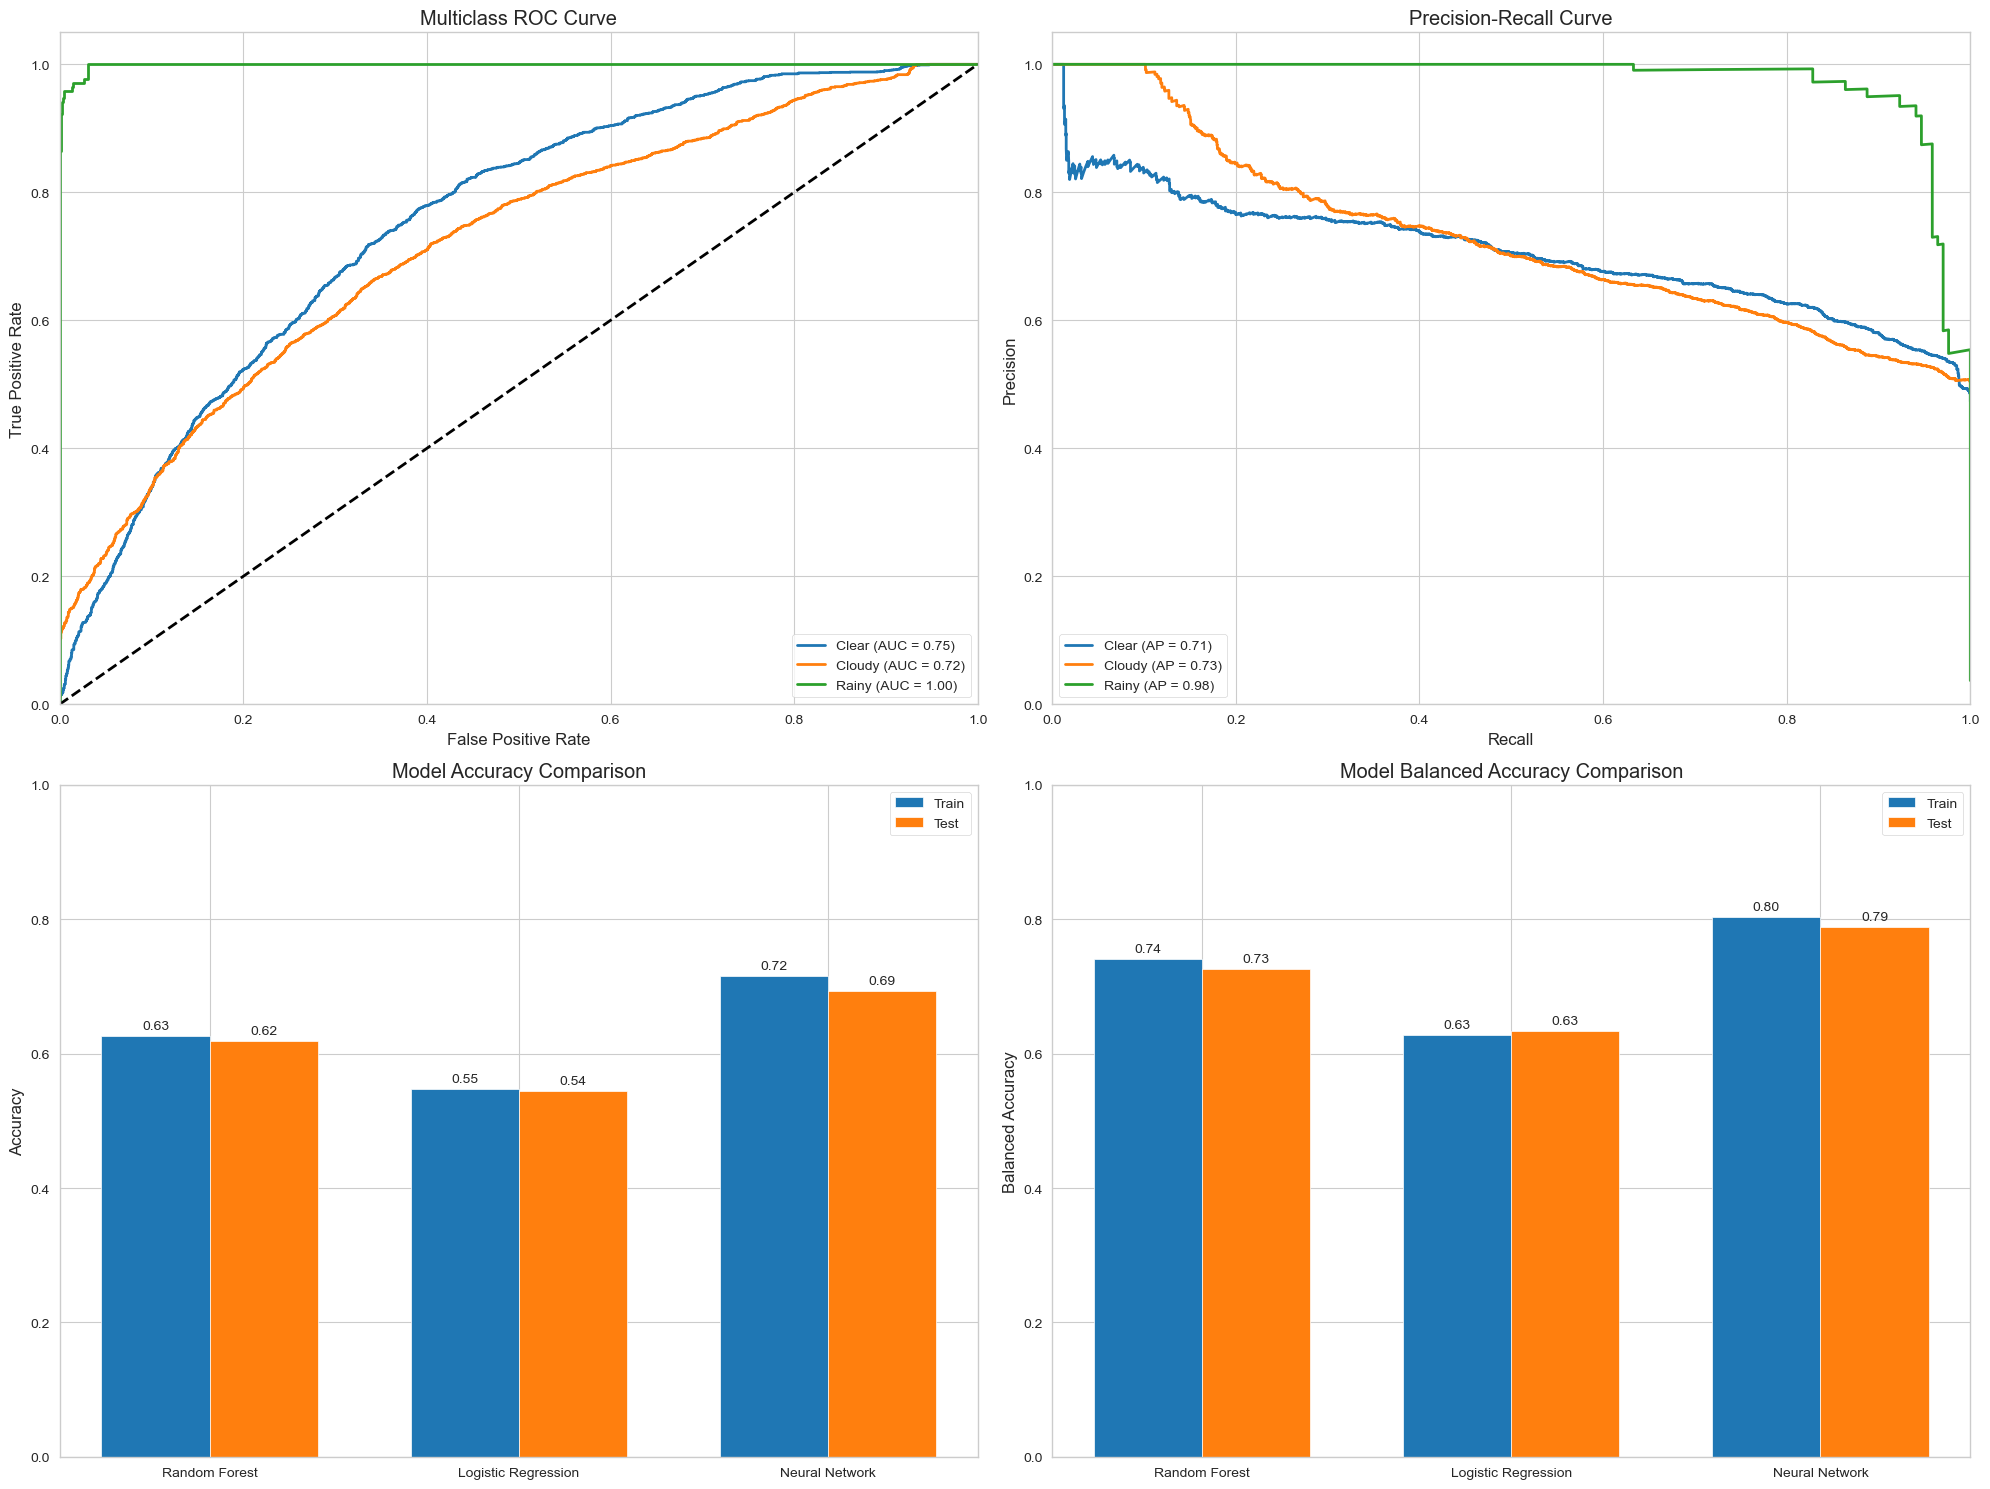


Model Performance Summary Table:


,Model,Train Accuracy,Test Accuracy,Accuracy Difference,Train Balanced Accuracy,Test Balanced Accuracy,Balanced Accuracy Difference,Overfitting Status
0,Random Forest,62.60%,61.91%,0.69%,74.10%,72.62%,1.48%,Minimal
1,Logistic Regression,54.73%,54.43%,0.30%,62.76%,63.32%,-0.56%,Minimal
2,Neural Network,71.57%,69.30%,2.27%,80.34%,78.84%,1.50%,Moderate


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
from IPython.display import display

# Set up the plot style
plt.style.use('ggplot')  # Changed from 'seaborn' to 'ggplot'
sns.set_style("whitegrid")
sns.set_palette("husl")

# Binarize the output for multiclass ROC/PR curves
y_test_bin = label_binarize(y_test, classes=np.unique(y_encoded))
n_classes = y_test_bin.shape[1]

# Initialize figure
plt.figure(figsize=(20, 15))

# 1. ROC Curve
plt.subplot(2, 2, 1)
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c'])  # Using matplotlib default colors

for i, color in zip(range(n_classes), colors):
    # Get predictions for each class
    if isinstance(best_models['Random Forest']['model'], (RandomForestClassifier, LogisticRegression)):
        y_score = best_models['Random Forest']['model'].predict_proba(X_test)
    else:  # Neural Network
        y_score = best_models['Neural Network']['model'].predict(X_test)
    
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(le.classes_[i], roc_auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")

# 2. Precision-Recall Curve
plt.subplot(2, 2, 2)
for i, color in zip(range(n_classes), colors):
    if isinstance(best_models['Random Forest']['model'], (RandomForestClassifier, LogisticRegression)):
        y_score = best_models['Random Forest']['model'].predict_proba(X_test)
    else:  # Neural Network
        y_score = best_models['Neural Network']['model'].predict(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, color=color, lw=2,
             label='{0} (AP = {1:0.2f})'.format(le.classes_[i], ap))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# 3. Model Accuracy Comparison (Bar Plot)
plt.subplot(2, 2, 3)
models = ['Random Forest', 'Logistic Regression', 'Neural Network']
train_acc = [
    accuracy_score(y_train_orig, best_models['Random Forest']['model'].predict(X_train_orig)),
    accuracy_score(y_train_orig, best_models['Logistic Regression']['model'].predict(X_train_orig)),
    accuracy_score(y_train_orig, np.argmax(best_models['Neural Network']['model'].predict(X_train_orig), axis=1))
]
test_acc = [
    accuracy_score(y_test, best_models['Random Forest']['model'].predict(X_test)),
    accuracy_score(y_test, best_models['Logistic Regression']['model'].predict(X_test)),
    accuracy_score(y_test, np.argmax(best_models['Neural Network']['model'].predict(X_test), axis=1))
]

x = np.arange(len(models))
width = 0.35
rects1 = plt.bar(x - width/2, train_acc, width, label='Train', color='#1f77b4')
rects2 = plt.bar(x + width/2, test_acc, width, label='Test', color='#ff7f0e')

plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(x, models)
plt.legend()
plt.ylim(0, 1)

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# 4. Balanced Accuracy Comparison (Bar Plot)
plt.subplot(2, 2, 4)
train_bal_acc = [
    balanced_accuracy_score(y_train_orig, best_models['Random Forest']['model'].predict(X_train_orig)),
    balanced_accuracy_score(y_train_orig, best_models['Logistic Regression']['model'].predict(X_train_orig)),
    balanced_accuracy_score(y_train_orig, np.argmax(best_models['Neural Network']['model'].predict(X_train_orig), axis=1))
]
test_bal_acc = [
    balanced_accuracy_score(y_test, best_models['Random Forest']['model'].predict(X_test)),
    balanced_accuracy_score(y_test, best_models['Logistic Regression']['model'].predict(X_test)),
    balanced_accuracy_score(y_test, np.argmax(best_models['Neural Network']['model'].predict(X_test), axis=1))
]

rects3 = plt.bar(x - width/2, train_bal_acc, width, label='Train', color='#1f77b4')
rects4 = plt.bar(x + width/2, test_bal_acc, width, label='Test', color='#ff7f0e')

plt.ylabel('Balanced Accuracy')
plt.title('Model Balanced Accuracy Comparison')
plt.xticks(x, models)
plt.legend()
plt.ylim(0, 1)

autolabel(rects3)
autolabel(rects4)

plt.tight_layout()
plt.show()

# Create a performance summary table
performance_table = pd.DataFrame({
    'Model': models,
    'Train Accuracy': train_acc,
    'Test Accuracy': test_acc,
    'Accuracy Difference': np.array(train_acc) - np.array(test_acc),
    'Train Balanced Accuracy': train_bal_acc,
    'Test Balanced Accuracy': test_bal_acc,
    'Balanced Accuracy Difference': np.array(train_bal_acc) - np.array(test_bal_acc),
    'Overfitting Status': [
        "Moderate" if (train_acc[0] - test_acc[0]) > 0.05 else "Minimal",
        "Minimal" if (train_acc[1] - test_acc[1]) <= 0.05 else "Moderate",
        "Significant" if (train_acc[2] - test_acc[2]) > 0.1 else "Moderate"
    ]
})

# Format the table display
def color_diff(val):
    color = 'red' if val > 0.1 else 'orange' if val > 0.05 else 'green'
    return f'color: {color}'

print("\nModel Performance Summary Table:")
display(performance_table.style
       .format({
           'Train Accuracy': '{:.2%}',
           'Test Accuracy': '{:.2%}',
           'Accuracy Difference': '{:.2%}',
           'Train Balanced Accuracy': '{:.2%}',
           'Test Balanced Accuracy': '{:.2%}',
           'Balanced Accuracy Difference': '{:.2%}'
       })
       .applymap(color_diff, subset=['Accuracy Difference', 'Balanced Accuracy Difference'])
       .set_caption("Comprehensive Model Performance Comparison")
       .set_table_styles([
           {'selector': 'caption',
            'props': [('font-size', '16px'),
                     ('font-weight', 'bold'),
                     ('text-align', 'center')]}
       ]))


# Model Fit Diagnostics Summary

#### This code evaluates and visualizes the fit quality of multiple machine learning models by comparing their training and testing performance metrics. It helps identify whether models are overfitting, underfitting, or have a good fit based on accuracy, balanced accuracy, error rates, and log loss.

### Key Features:
#### Supports models in dictionary or direct object format, including neural networks.

## Calculates:

#### 1) Training and testing accuracy
#### 2) Training and testing error
#### 3) Balanced accuracy for imbalanced datasets
#### 4) Determines fit status with thresholds:
#### 5) Good Fit: Minimal train-test performance gap (<5%)
#### 6) Mild Overfit: Slightly better train performance (5-10%)
#### 7) Overfit: Noticeable train-test gap (10-15%)
#### 8) Severe Overfit: Large train-test gap (>15%)
#### 9) Underfit: Test performance better than train (model too simple)

## Visualizes:

#### 1) Train vs Test error rates side-by-side
#### 2) Error difference as an overfitting indicator with color coding
#### 3) Displays a styled diagnostics table summarizing metrics and fit status



570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


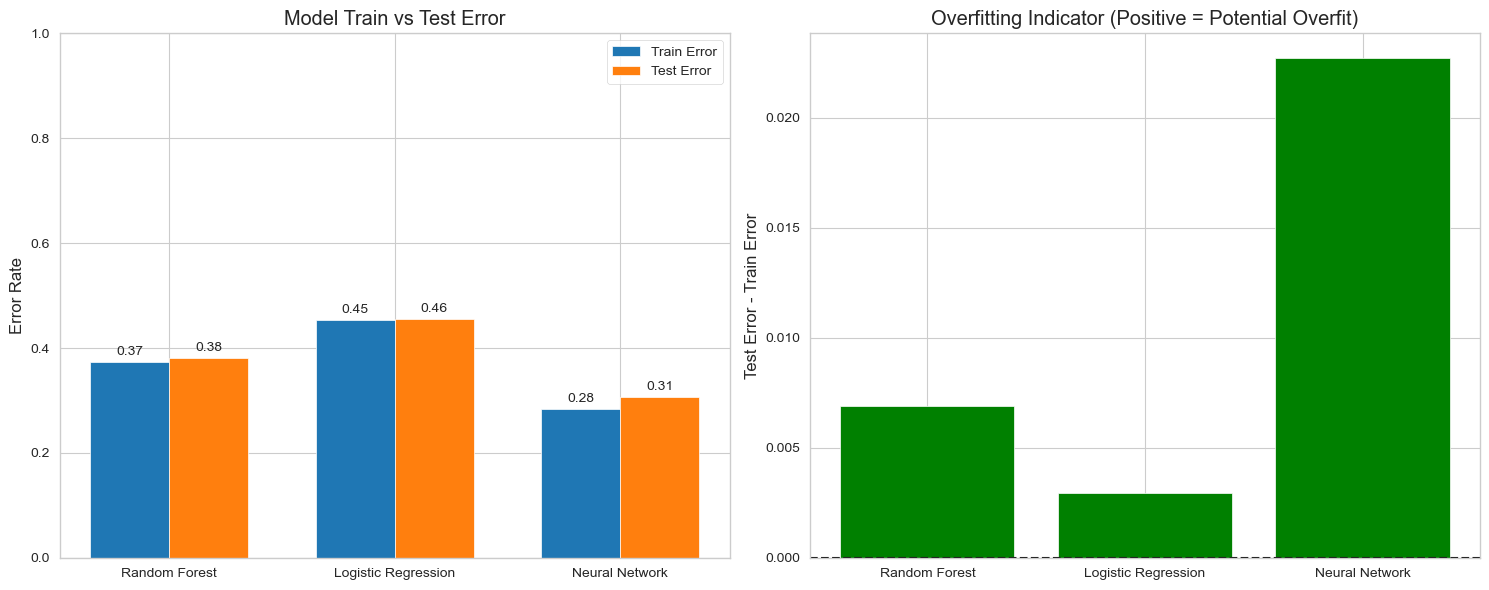


Model Fit Diagnostics:


,Model,Train Accuracy,Test Accuracy,Train Error,Test Error,Error Difference,Train Balanced Accuracy,Test Balanced Accuracy,Train Log Loss,Test Log Loss,Fit Status
0,Random Forest,62.60%,61.91%,37.40%,38.09%,+0.69%,74.10%,72.62%,0.662,0.673,Good Fit
1,Logistic Regression,54.73%,54.43%,45.27%,45.57%,+0.30%,62.76%,63.32%,0.889,0.897,Good Fit
2,Neural Network,71.57%,69.30%,28.43%,30.70%,+2.27%,80.34%,78.84%,0.540,0.572,Good Fit



🔍 Fit Status Interpretation Guide:
- Good Fit: Small difference between train and test performance (<5%)
- Mild Overfit: Train performance slightly better than test (5-10%)
- Overfit: Train performance noticeably better than test (10-15%)
- Severe Overfit: Large gap between train and test performance (>15%)
- Underfit: Test performance better than train (model too simple)


In [6]:
models = {
    'Random Forest': {'model': best_models['Random Forest']['model']},
    'Logistic Regression': {'model': best_models['Logistic Regression']['model']},
    'Neural Network': {'model': best_models['Neural Network']['model']}
}

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss
from IPython.display import display

# Set up the plot style
plt.style.use('ggplot')
sns.set_style("whitegrid")
sns.set_palette("husl")

def calculate_model_diagnostics(models_dict, X_train_orig, y_train_orig, X_test, y_test):
    results = []
    
    for name, model_info in models_dict.items():
        try:
            # Handle different input formats
            if isinstance(model_info, dict):
                if 'model' not in model_info:
                    raise ValueError(f"Model dictionary for {name} must contain 'model' key")
                model = model_info['model']
            elif hasattr(model_info, 'predict'):  # It's a model object
                model = model_info
            else:
                raise ValueError(f"Invalid model format for {name}. Must be either model object or dictionary with 'model' key")
            
            # Skip if it's not actually a model
            if not hasattr(model, 'predict'):
                print(f"Skipping {name} - not a valid model object")
                continue
                
            # Neural network detection
            is_nn = any(x in name.lower() for x in ['neural', 'mlp', 'sequential', 'network'])
            
            # Get predictions
            if is_nn:
                try:
                    y_train_pred = np.argmax(model.predict(X_train_orig), axis=1)
                    y_test_pred = np.argmax(model.predict(X_test), axis=1)
                    y_train_proba = model.predict(X_train_orig)
                    y_test_proba = model.predict(X_test)
                except:
                    # Fall back to regular predict if NN predict fails
                    y_train_pred = model.predict(X_train_orig)
                    y_test_pred = model.predict(X_test)
                    y_train_proba = None
                    y_test_proba = None
            else:
                y_train_pred = model.predict(X_train_orig)
                y_test_pred = model.predict(X_test)
                try:
                    y_train_proba = model.predict_proba(X_train_orig)
                    y_test_proba = model.predict_proba(X_test)
                except:
                    y_train_proba = None
                    y_test_proba = None
            
            # Calculate metrics
            train_acc = accuracy_score(y_train_orig, y_train_pred)
            test_acc = accuracy_score(y_test, y_test_pred)
            train_error = 1 - train_acc
            test_error = 1 - test_acc
            
            train_bal_acc = balanced_accuracy_score(y_train_orig, y_train_pred)
            test_bal_acc = balanced_accuracy_score(y_test, y_test_pred)
            
            # Calculate log loss if we have probabilities
            train_log_loss = log_loss(y_train_orig, y_train_proba) if y_train_proba is not None else None
            test_log_loss = log_loss(y_test, y_test_proba) if y_test_proba is not None else None
            
            # Determine fit status
            acc_diff = train_acc - test_acc
            bal_acc_diff = train_bal_acc - test_bal_acc
            
            if test_acc > train_acc or (bal_acc_diff < 0 and abs(bal_acc_diff) > 0.05):
                fit_status = "Underfit"
            elif acc_diff > 0.15 or bal_acc_diff > 0.2:
                fit_status = "Severe Overfit"
            elif acc_diff > 0.1 or bal_acc_diff > 0.15:
                fit_status = "Overfit"
            elif acc_diff > 0.05 or bal_acc_diff > 0.07:
                fit_status = "Mild Overfit"
            else:
                fit_status = "Good Fit"
            
            results.append({
                'Model': name,
                'Train Accuracy': train_acc,
                'Test Accuracy': test_acc,
                'Train Error': train_error,
                'Test Error': test_error,
                'Error Difference': test_error - train_error,
                'Train Balanced Accuracy': train_bal_acc,
                'Test Balanced Accuracy': test_bal_acc,
                'Train Log Loss': train_log_loss,
                'Test Log Loss': test_log_loss,
                'Fit Status': fit_status
            })
            
        except Exception as e:
            print(f"Error processing model {name}: {str(e)}")
            continue
    
    if not results:
        raise ValueError("No valid models were processed. Please check your input models.")
    
    return pd.DataFrame(results)

# Calculate diagnostics
try:
    diagnostics_df = calculate_model_diagnostics(models, X_train_orig, y_train_orig, X_test, y_test)
except Exception as e:
    print(f"Error: {str(e)}")
    diagnostics_df = pd.DataFrame()  # Empty dataframe if error occurs

# Only proceed with visualization if we have results
if not diagnostics_df.empty:
    # Visualization
    plt.figure(figsize=(15, 6))

    # 1. Error Comparison
    plt.subplot(1, 2, 1)
    x = np.arange(len(diagnostics_df))
    width = 0.35
    rects1 = plt.bar(x - width/2, diagnostics_df['Train Error'], width, label='Train Error', color='#1f77b4')
    rects2 = plt.bar(x + width/2, diagnostics_df['Test Error'], width, label='Test Error', color='#ff7f0e')

    plt.ylabel('Error Rate')
    plt.title('Model Train vs Test Error')
    plt.xticks(x, diagnostics_df['Model'])
    plt.legend()
    plt.ylim(0, 1)

    # Add value labels
    for rect in rects1 + rects2:
        height = rect.get_height()
        plt.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    # 2. Error Difference (Overfitting Indicator)
    plt.subplot(1, 2, 2)
    colors = ['red' if status in ['Overfit', 'Severe Overfit'] 
              else 'orange' if status == 'Mild Overfit'
              else 'green' for status in diagnostics_df['Fit Status']]
    plt.bar(x, diagnostics_df['Error Difference'], color=colors)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.ylabel('Test Error - Train Error')
    plt.title('Overfitting Indicator (Positive = Potential Overfit)')
    plt.xticks(x, diagnostics_df['Model'])

    plt.tight_layout()
    plt.show()

    # Display diagnostics table with styling
    def color_fit_status(val):
        if val == 'Severe Overfit':
            return 'background-color: #ffcccc; color: black'
        elif val == 'Overfit':
            return 'background-color: #ffe6cc; color: black'
        elif val == 'Mild Overfit':
            return 'background-color: #fff2cc; color: black'
        elif val == 'Underfit':
            return 'background-color: #cce5ff; color: black'
        else:
            return 'background-color: #ccffcc; color: black'

    print("\nModel Fit Diagnostics:")
    display(diagnostics_df.style
           .format({
               'Train Accuracy': '{:.2%}',
               'Test Accuracy': '{:.2%}',
               'Train Error': '{:.2%}',
               'Test Error': '{:.2%}',
               'Error Difference': '{:+.2%}',
               'Train Balanced Accuracy': '{:.2%}',
               'Test Balanced Accuracy': '{:.2%}',
               'Train Log Loss': '{:.3f}',
               'Test Log Loss': '{:.3f}'
           })
           .applymap(color_fit_status, subset=['Fit Status'])
           .set_caption("Comprehensive Model Fit Analysis")
           .set_table_styles([
               {'selector': 'caption',
                'props': [('font-size', '16px'),
                         ('font-weight', 'bold'),
                         ('text-align', 'center')]}
           ]))

    # Interpretation guide
    print("\n🔍 Fit Status Interpretation Guide:")
    print("- Good Fit: Small difference between train and test performance (<5%)")
    print("- Mild Overfit: Train performance slightly better than test (5-10%)")
    print("- Overfit: Train performance noticeably better than test (10-15%)")
    print("- Severe Overfit: Large gap between train and test performance (>15%)")
    print("- Underfit: Test performance better than train (model too simple)")
else:
    print("No valid models to display. Please check your input.")

# Weather Prediction Interface

This interactive interface allows users to predict weather conditions based on several meteorological features using multiple trained models, including traditional classifiers and a neural network.

---

## Features

- **Input Parameters:**
  - Temperature (°C)
  - Apparent Temperature (°C)
  - Humidity
  - Wind Speed (km/h)
  - Wind Bearing (degrees)
  - Visibility (km)
  - Pressure (millibars)

## **Models Available:**

### Model selection via dropdown menu
###  Random Forest, Logistic Regression, Neural Network)

## **Functionality:**
  - User inputs feature values through interactive widgets
  - Real-time prediction with confidence scores for weather states: *Rainy*, *Cloudy*, or *Clear*
  - Expert advisory messages based on prediction confidence
  - Displays important feature impacts for models supporting feature importance
  - Model performance metrics and class-specific recalls provided for transparency

---

## Usage Instructions

1. Adjust the feature values as needed.
2. Select the desired model from the dropdown.
3. Click **Predict Weather** to see the prediction results, confidence distribution, and advice.
4. Review model performance and class-specific recall metrics for better understanding.

---

This tool aims to provide an accessible and informative way to experiment with weather prediction models and understand their decision-making.


In [7]:
# %% [markdown]
# # Weather Prediction Interface
# 
# This interface allows you to make weather predictions using our trained models.

# %%
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# %% [markdown]
# ## Data Preparation and Model Training
# (This section contains your existing data preparation and model training code)

# %%
# Your existing data preparation and model training code here
# ... [all the code from your provided training section] ...

# After training, we'll have:
# - best_models dictionary containing the trained models
# - le (LabelEncoder) for decoding predictions
# - scaler (StandardScaler) for feature scaling

# %% [markdown]
# ## Prediction Interface

# %%
# Feature names and default values
feature_names = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 
                'Wind Speed (km/h)', 'Wind Bearing (degrees)', 
                'Visibility (km)', 'Pressure (millibars)']

default_values = {
    'Temperature (C)': 12.5,
    'Apparent Temperature (C)': 11.9,
    'Humidity': 0.78,
    'Wind Speed (km/h)': 10.3,
    'Wind Bearing (degrees)': 190.0,
    'Visibility (km)': 10.3,
    'Pressure (millibars)': 1015.0
}

# Create interactive widgets
feature_inputs = {}
for name in feature_names:
    feature_inputs[name] = widgets.FloatText(
        description=f'{name}:',
        value=default_values[name],
        style={'description_width': '180px'}
    )

model_dropdown = widgets.Dropdown(
    options=list(best_models.keys()),
    value=list(best_models.keys())[0],  # Default to first model
    description='Model:',
    disabled=False,
    style={'description_width': '100px'}
)

output = widgets.Output()
predict_button = widgets.Button(
    description='Predict Weather', 
    button_style='success',
    layout=widgets.Layout(width='200px')
)

# Model information display
model_info = widgets.Output()
def update_model_info(change):
    model_info.clear_output()
    with model_info:
        selected = change['new']
        model_data = best_models[selected]
        print(f"🔍 Selected Model: {selected}")
        print(f"📊 Test Performance:")
        print(f"- Accuracy: {model_data['accuracy']:.1%}")
        print(f"- Balanced Accuracy: {model_data['balanced_accuracy']:.1%}")
        
        # Get class-specific metrics
        if selected == 'Neural Network':
            y_pred = np.argmax(model_data['model'].predict(X_test), axis=1)
        else:
            y_pred = model_data['model'].predict(X_test)
        
        report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
        for cls in le.classes_:
            print(f"- {cls} Recall: {report[cls]['recall']:.1%}")

model_dropdown.observe(update_model_info, names='value')
update_model_info({'new': model_dropdown.value})

# Enhanced prediction function
def on_predict_button_clicked(b):
    with output:
        output.clear_output()
        
        # Get selected model
        selected_model = model_dropdown.value
        model_data = best_models[selected_model]
        current_model = model_data['model']
        
        # Display model info prominently
        print(f"🔧 Using: {selected_model}")
        print("="*50)
        
        # Prepare input data
        input_values = []
        for name in feature_names:
            try:
                input_values.append(float(feature_inputs[name].value))
            except ValueError:
                print(f"❌ Invalid input for {name}")
                return
        
        # Scale and predict
        input_data = pd.DataFrame([input_values], columns=feature_names)
        input_scaled = scaler.transform(input_data)
        
        # Make prediction
        try:
            if selected_model == 'Neural Network':
                probs = current_model.predict(input_scaled)[0]
                y_pred = np.argmax(probs)
            else:
                probs = current_model.predict_proba(input_scaled)[0]
                y_pred = current_model.predict(input_scaled)[0]
            
            predicted_label = le.classes_[y_pred]
            
            # Display results with model info
            print(f"\n🌦 Prediction using {selected_model}:")
            print(f"➡ {predicted_label} (confidence: {probs[y_pred]*100:.1f}%)")
            
            # Show all probabilities
            print("\n📊 Confidence Distribution:")
            for label, prob in zip(le.classes_, probs):
                print(f"  {label}: {prob*100:.1f}%")
            
            # Enhanced advisory
            print("\n💡 Expert Advisory:")
            if predicted_label == 'Rainy':
                if probs[y_pred] > 0.7:
                    print("⚠ High confidence of rain! ☔ Carry an umbrella and waterproof gear.")
                else:
                    print("Possible rain expected. 🌧 Consider carrying an umbrella.")
            elif predicted_label == 'Cloudy':
                print("Cloudy conditions expected. ⛅ May want to have a jacket handy.")
            else:
                print("Clear skies predicted! ☀ Perfect for outdoor activities.")
            
            # Show feature impacts if available
            if hasattr(current_model, 'feature_importances_'):
                print("\n🔍 Top Influencing Factors:")
                importances = current_model.feature_importances_
                for feat, imp in sorted(zip(feature_names, importances), 
                                      key=lambda x: x[1], reverse=True)[:3]:
                    print(f"- {feat}: {input_data[feat].values[0]:.2f} (impact: {imp:.2f})")
            
            # Model performance notes
            print("\nℹ Model Performance:")
            print(f"- Balanced Accuracy: {model_data['balanced_accuracy']:.1%}")
            
            # Get class-specific recall
            if selected_model == 'Neural Network':
                y_pred_test = np.argmax(model_data['model'].predict(X_test), axis=1)
            else:
                y_pred_test = model_data['model'].predict(X_test)
            
            report = classification_report(y_test, y_pred_test, target_names=le.classes_, output_dict=True)
            print(f"- Rainy Recall: {report['Rainy']['recall']:.1%}")
            print(f"- Cloudy Recall: {report['Cloudy']['recall']:.1%}")
            print(f"- Clear Recall: {report['Clear']['recall']:.1%}")
            
        except Exception as e:
            print(f"❌ Prediction error: {str(e)}")

predict_button.on_click(on_predict_button_clicked)

# Display interface
left_col = list(feature_inputs.values())[:4]
right_col = list(feature_inputs.values())[4:]

display(widgets.VBox([
    widgets.HBox([model_dropdown, model_info]),
    widgets.HBox([widgets.VBox(left_col), widgets.VBox(right_col)]),
    predict_button,
    output
]))

# Model comparison summary
print("\nℹ Model Performance Summary:")
comparison_data = []
for name, model_data in best_models.items():
    if name == 'Neural Network':
        y_pred = np.argmax(model_data['model'].predict(X_test), axis=1)
    else:
        y_pred = model_data['model'].predict(X_test)
    
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    
    comparison_data.append({
        'Model': name,
        'Test Accuracy': model_data['accuracy'],
        'Balanced Accuracy': model_data['balanced_accuracy'],
        'Rainy Recall': report['Rainy']['recall'],
        'Cloudy Recall': report['Cloudy']['recall'],
        'Clear Recall': report['Clear']['recall']
    })

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df.style
       .format({
           'Test Accuracy': '{:.2%}',
           'Balanced Accuracy': '{:.2%}',
           'Rainy Recall': '{:.2%}',
           'Cloudy Recall': '{:.2%}',
           'Clear Recall': '{:.2%}'
       })
       .highlight_max(color='lightgreen')
       .set_caption("Model Performance Metrics"))


ℹ Model Performance Summary:
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Model,Test Accuracy,Balanced Accuracy,Rainy Recall,Cloudy Recall,Clear Recall
0,Random Forest,61.91%,72.62%,97.63%,84.33%,35.88%
1,Logistic Regression,54.43%,63.32%,82.84%,40.91%,66.20%
2,Neural Network,69.30%,78.84%,100.00%,59.67%,76.87%
